In [ ]:
%load_ext autoreload
%autoreload 2
from dpe import DPE
from lib_data import *
import matplotlib.pyplot as plt
import numpy as np
from lib_nn_dpe import NN_dpe
from IPython import display

import serial
%config InlineBackend.figure_formats = ['svg']

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"

In [ ]:
dpe = DPE('COM3')
dpe.set_clock(50)
dpe.shape

....

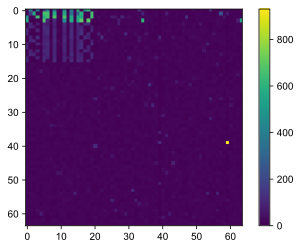

In [51]:
g = dpe.read(1, Tdly=1000)
plt.imshow(g * 1e6)
plt.colorbar()

In [13]:
#%%
table = [
    [0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
    [0, 1, 0, 1, 1, 0, 0, 0, 1, 0],
    [1, 0, 0, 1, 1, 0, 0, 0, 1, 0],
    [1, 2, 0, 1, 1, 0, 0, 0, 1, 1]
]

ns = [
    [0, 1],
    [1, 0],
    [1, 0],
    [1, 1]
]

from lib_tcam import *

G = gen_tcam_2r(table).T

G = np.concatenate( (G, G, G, G))

(16, 20)

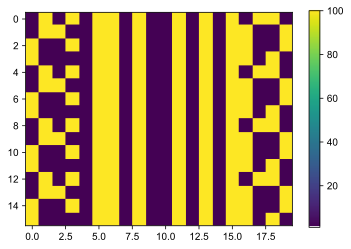

In [14]:
plt.imshow(G*1e6)
plt.colorbar()
G.shape

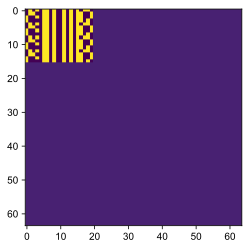

In [15]:
N = 64
targetTolerance = 4e-6

targetG = np.zeros((N,N)) + 10e-6
targetG[:G.shape[0], :G.shape[1]] = G

targetGTolerance = np.full((N, N), np.inf)
targetGTolerance[:G.shape[0], :G.shape[1]] = targetTolerance

plt.imshow(targetG)

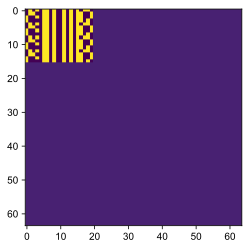

In [16]:
vSetRamp = [1, 3.5, 1]
vGateSetRamp = [0.5, 1.4, 0.05]
vResetRamp = [0.3, 1.5, 0.05]
vGateResetRamp = [5.0, 5.5, 0.5]

maxSteps = 200
array = 1
shape = [64, 64]

# Gtarget = np.ones(shape) * 40e-6
Gtarget = targetG
Gtol = targetTolerance

Msel = np.ones(shape)
# Msel[:16,:20] = 1

Ghist = []
vSetHist = []
vGateSetHist = []
vResetHist = []
vResetGateHist = []

vSet = np.zeros(shape) 
vGateSet = np.zeros(shape)
vReset = np.zeros(shape)
vGateReset = np.zeros(shape)

Mset_pre = np.zeros(shape)
Mreset_pre = np.zeros(shape)

Mbound = np.zeros(shape)
maxBound = 5

plt.imshow(Gtarget * Msel)

KeyboardInterrupt: 

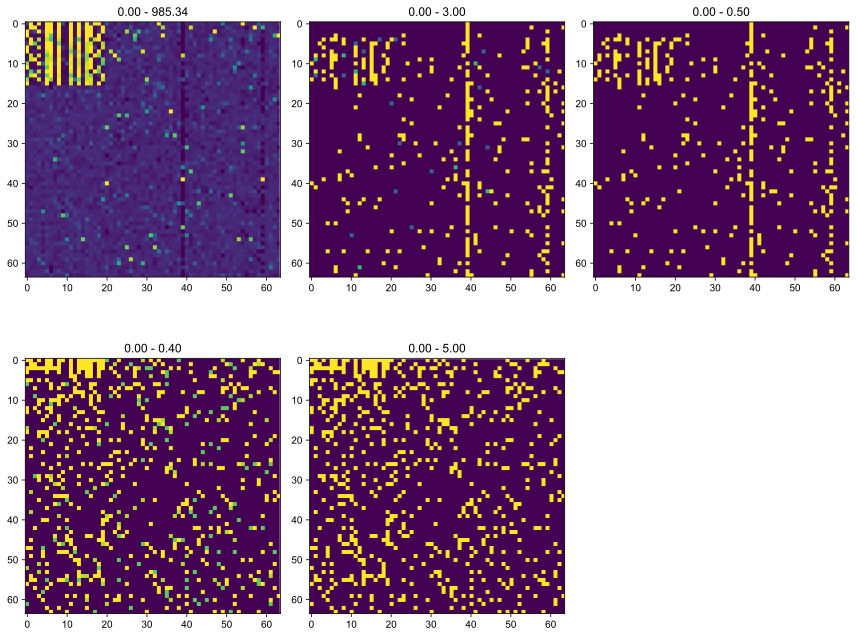

In [17]:
for s in range(maxSteps):
    Gread = dpe.read(array, Tdly=500)
    Ghist.append(Gread)
    
    Mset = ((Gread - Gtarget) < -Gtol) * Msel
    Mreset = ((Gread - Gtarget) > Gtol) * Msel
    
    vSet = vSet * Mset
    vGateSet = vGateSet * Mset
    vReset = vReset * Mreset
    vGateReset = vGateReset * Mreset

#     Pover
        # Adjust programming parameters
    for i in range(shape[0]):
        for j in range(shape[1]):

            if Mset[i,j] == 1:
                if vSet[i,j] == 0 or vGateSet[i,j] == 0:
                    # Initiate
                    vSet[i,j] = vSetRamp[0]
                    vGateSet[i,j] = vGateSetRamp[0]
                    Mbound[i,j] = 0
                else:
                    vSet[i,j] += vSetRamp[-1]

                    if vSet[i,j] > vSetRamp[1]:
                        vGateSet[i,j] += vGateSetRamp[-1]

                        if vGateSet[i,j] > vGateSetRamp[1]:
                            vGateSet[i,j] = vGateSetRamp[1]
                            vSet[i,j] = vSetRamp[1]
                            Mbound[i,j] += 1
                        else:
                            vSet[i,j] = vSetRamp[0]


            if Mreset[i,j] == 1:
                if vReset[i,j] == 0 or vGateReset[i,j] == 0:
                    # Initiate
                    vReset[i,j] = vResetRamp[0]
                    vGateReset[i,j] = vGateResetRamp[0]
                    Mbound[i,j] = 0
                else:
                    vReset[i,j] += vResetRamp[-1]

                    if vReset[i,j] > vResetRamp[1]:
                        vGateReset[i,j] += vGateResetRamp[-1]

                        if vGateReset[i,j] > vGateResetRamp[1]:
                            vGateReset[i,j] = vGateResetRamp[1]
                            vReset[i,j] = vResetRamp[1]
                            Mbound[i,j] += 1
                        else:
                            vReset[i,j] = vSetRamp[0]
                        
    vSetHist.append(vSet)
    vGateSetHist.append(vGateSet * (Mbound<=maxBound))
    vResetHist.append(vReset)
    vResetGateHist.append(vGateReset * (Mbound<=maxBound))
    
    plt.figure(1, figsize=(12,10))
    plt.subplot(2,3,1)
    plt.imshow(Gread * 1e6)
    plt.title(f'{Gread.min()*1e6:.2f} - {Gread.max()*1e6:.2f}')
    plt.clim(0, 100)
    
    plt.subplot(2,3,2)
    plt.imshow(vSet)
    plt.title(f'{vSet.min():.2f} - {vSet.max():.2f}')
    
    plt.subplot(2,3,3)
    plt.imshow(vGateSet * (Mbound<=maxBound))
    plt.title(f'{vGateSet.min():.2f} - {vGateSet.max():.2f}')
    
    plt.subplot(2,3,4)
    plt.imshow(vReset)
    plt.title(f'{vReset.min():.2f} - {vReset.max():.2f}')
    
    plt.subplot(2,3,5)
    plt.imshow(vGateReset * (Mbound<=maxBound))
    plt.title(f'{vGateReset.min():.2f} - {vGateReset.max():.2f}')
    
    plt.tight_layout()
    
    display.clear_output(wait=True)
    display.display(plt.gcf())

    print(f'St-art programming, step={s}, maxBound={sum((Mbound>=maxBound).reshape(-1))} ' +
          f'yield= {sum( ((np.abs(Gread-Gtarget)<Gtol) * Msel).reshape(-1)) / sum(Msel.reshape(-1))*100:.2f}%')
    
    # Start programming
    dpe.set(array, vSet, vGateSet * (Mbound<=maxBound), verbose=True, Twidth=20e-9)
    dpe.reset(array, vReset, vGateReset * (Mbound<=maxBound), verbose=True, Twidth=20e-9)

Text(0, 0.5, 'Reset voltages')

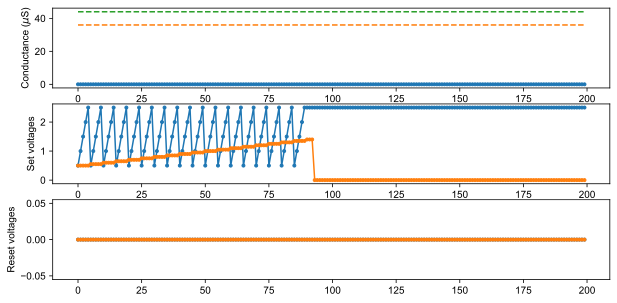

In [24]:
vSetHist = np.array(vSetHist)
vGateSetHist = np.array(vGateSetHist)

Ghist = np.array(Ghist)
vResetHist = np.array(vResetHist)
vResetGateHist = np.array(vResetGateHist)


x = 32
y = 5

plt.figure(figsize=(10,5))
plt.subplot(311)
plt.plot(Ghist[:, x, y]*1e6, '.-')
plt.plot([0, len(Ghist[:, x, y])-1], [(Gtarget[x,y]-Gtol)*1e6, (Gtarget[x,y]-Gtol)*1e6], '--')
plt.plot([0, len(Ghist[:, x, y])-1], [(Gtarget[x,y]+Gtol)*1e6, (Gtarget[x,y]+Gtol)*1e6], '--')
plt.ylabel('Conductance ($\mu$S)')

plt.subplot(312)
plt.plot(vSetHist[:, x, y], '.-')
plt.plot(vGateSetHist[:, x, y], '.-')
plt.ylabel('Set voltages')

plt.subplot(313)
plt.plot(vResetHist[:, x, y], '.-')
plt.plot(vResetGateHist[:, x, y], '.-')
plt.ylabel('Reset voltages')

In [88]:
from lib_data import *
save_workspace(vars(), note='prog_array1_tcam')

Saving In(<class 'list'>), Out(<class 'dict'>), g(<class 'numpy.ndarray'>), table(<class 'list'>), ns(<class 'list'>), V_read(<class 'float'>), G(<class 'numpy.ndarray'>), N(<class 'int'>), targetTolerance(<class 'float'>), targetG(<class 'numpy.ndarray'>), targetGTolerance(<class 'numpy.ndarray'>), vSetRamp(<class 'list'>), vGateSetRamp(<class 'list'>), vResetRamp(<class 'list'>), vGateResetRamp(<class 'list'>), maxSteps(<class 'int'>), array(<class 'int'>), shape(<class 'list'>), Gtarget(<class 'numpy.ndarray'>), Gtol(<class 'float'>), Msel(<class 'numpy.ndarray'>), Ghist(<class 'list'>), vSetHist(<class 'list'>), vGateSetHist(<class 'list'>), vResetHist(<class 'list'>), vResetGateHist(<class 'list'>), vSet(<class 'numpy.ndarray'>), vGateSet(<class 'numpy.ndarray'>), vReset(<class 'numpy.ndarray'>), vGateReset(<class 'numpy.ndarray'>), Mset_pre(<class 'numpy.ndarray'>), Mreset_pre(<class 'numpy.ndarray'>), Mbound(<class 'numpy.ndarray'>), maxBound(<class 'int'>), s(<class 'int'>), Gr

In [19]:
load_workspace(vars(), '20191209-165345-prog_array0')

Loaded: In, Out, a, Twidth, g, Vreset, Vgate, vSetRamp, vGateSetRamp, vResetRamp, vGateResetRamp, maxLoops, array, maxSteps, s, shape, Ginit, Gtarget, Ghist, Gcurr, Gerror, Msel, Gtorr, Mprog, Mreset, Mset, Gread, vSetPt, vGateSetPt, vResetPt, vGateResetPt, vSet, vGateSet, vReset, vGateReset, Mset_pre, Mreset_pre, Mbound, maxBound, i, j, vSetHist, vGateSetHist, vResetHist, vResetGateHist, x, y, 


(array([  3.,   5.,   3.,   7.,   8.,  37., 106.,  33.,  19.,  22.,  29.,
         22.,  31.,  20.,  16.,  12.,   3.,   1.,   3.,   2.,   0.,   0.,
          1.,   1.,   1.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   2.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.]), array([  3.83186706,   9.40449658,  14.9771261 ,  20.54975562,
         26.12238514,  31.69501466,  37.26764418,  42.8402737 ,
         48.41290323,  53.98553275,  59.55816227,  65.13079179,
         70.70342131,  76.27605083,  81.84868035,  87.42130987,
         92.99393939,  98.56656891, 104.13919844, 109.71182796,

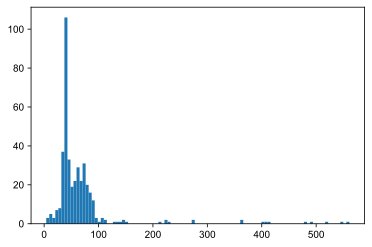

In [10]:
# Gtmp = Gread
# Gtmp[Gtmp<2e-6] = np.nan

plt.hist(Gread[Gread>2e-6].reshape(-1)*1e6, 100)

In [17]:
dpe.reset(1, 1.2, 5.5)

....

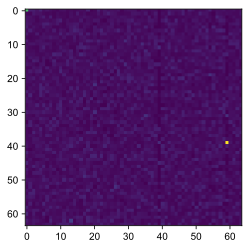

In [18]:
plt.imshow(dpe.read(1))

..1


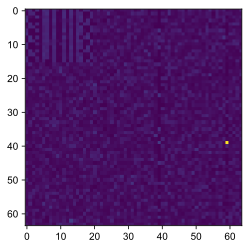

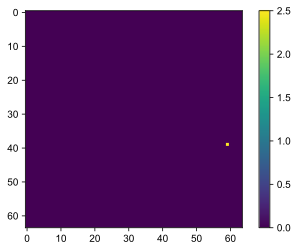

In [51]:
g = dpe.read(1, Tdly=500)
plt.figure()
plt.imshow(g)

Vreset = np.ones((64,64)) * 2.5
Vgate = np.ones((64,64)) * 5.5

Vreset = Vreset * (g>200e-6)
Vgate = Vgate * (g>200e-6)
plt.figure()
plt.imshow(Vreset)
plt.colorbar()

print( sum(g.reshape(-1)>200e-6))

In [48]:
dpe.reset(0, Vreset, Vgate, verbose=True, Twidth=1000e-3)

Resetting 1 devices...
Programming with external timing Twidth=1000000.0 us
.

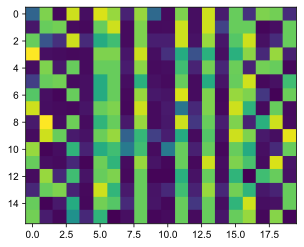

In [52]:
plt.imshow(g[:G.shape[0], :G.shape[1]])

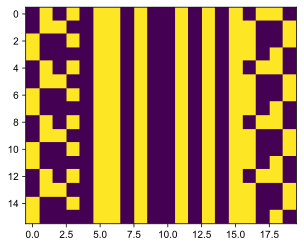

In [53]:
plt.imshow(G)

In [101]:
x = lambda : None

In [28]:
Gtarget = np.ones((64,64)) * 60e-6

In [58]:
def myplot(data):
#     Gread = data['Ghist'][-1]
#     vSet = data['vSetHist'][-1]
#     vGateSet = data['vGateSetHist'][-1]
#     vReset = data['vResetHist'][-1]
#     vGateReset = data['vGateResetHist'][-1]
    
    
#     plt.figure(1, figsize=(12,10))
#     plt.subplot(2,3,1)
#     plt.imshow(Gread * 1e6)
#     plt.title(f'{Gread.min()*1e6:.2f} - {Gread.max()*1e6:.2f}')
#     plt.clim(0, 100)
    
#     plt.subplot(2,3,2)
#     plt.imshow(vSet)
#     plt.title(f'{vSet.min():.2f} - {vSet.max():.2f}')
    
#     plt.subplot(2,3,3)
#     plt.imshow(vGateSet )
#     plt.title(f'{vGateSet.min():.2f} - {vGateSet.max():.2f}')
    
#     plt.subplot(2,3,4)
#     plt.imshow(vReset)
#     plt.title(f'{vReset.min():.2f} - {vReset.max():.2f}')
    
#     plt.subplot(2,3,5)
#     plt.imshow(vGateReset )
#     plt.title(f'{vGateReset.min():.2f} - {vGateReset.max():.2f}')
    
#     plt.tight_layout()
    
    display.clear_output(wait=True)
#     display.display(plt.gcf())

In [59]:
# data = dpe.tune_conductance(0,  Gtarget, saveHistory=True, plot_callback=myplot, maxSteps=200, method='fast')

data = dpe.tune_conductance(0,  Gtarget, saveHistory=True, maxSteps=200, method='fast')

St-art programming, step=199, maxBound=3713 yield= 6.71%
Setting 56 devices...
Programming with internal timing P_RESET=2
Resetting 53 devices...
Programming with internal timing P_RESET=2


In [44]:
data.keys()

dict_keys(['Ghist', 'vSetHist', 'vGateSetHist', 'vResetHist', 'vResetGateHist'])

....

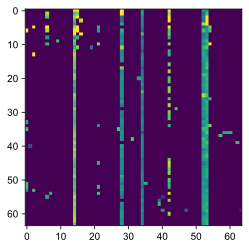

In [62]:
plt.imshow(dpe.read(0, method='slow'), clim=(0, 100e-6))